# IV. Scenarios

## Load the data

In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from math import sqrt
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
London_OD = pd.read_csv("data/london_flows.csv")

In [3]:
London_OD

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [4]:
# Check the data
has_zeros_population = (London_OD['population'] == 0).any()
print(f"'population' contains zeros: {has_zeros_population}")
has_negatives_population = (London_OD['population'] < 0).any()
print(f"'population' contains negatives: {has_negatives_population}")

has_zeros_jobs = (London_OD['jobs'] == 0).any()
has_negatives_jobs = (London_OD['jobs'] < 0).any()
print(f"'jobs' contains zeros: {has_zeros_jobs}")
print(f"'jobs' contains negatives: {has_negatives_jobs}")

has_zeros_distance = (London_OD['distance'] == 0).any()
has_negatives_distance = (London_OD['distance'] < 0).any()
print(f"'distance' contains zeros: {has_zeros_distance}")
print(f"'distance' contains negatives: {has_negatives_distance}")

'population' contains zeros: True
'population' contains negatives: False
'jobs' contains zeros: True
'jobs' contains negatives: False
'distance' contains zeros: True
'distance' contains negatives: False


In [5]:
# Replace zero with NaN to avoid errors in subsequent logarithmic transformations
London_OD['population'] = London_OD['population'].apply(lambda x: np.nan if x == 0 else x)
London_OD['jobs'] = London_OD['jobs'].apply(lambda x: np.nan if x == 0 else x)
London_OD['distance'] = London_OD['distance'].apply(lambda x: np.nan if x == 0 else x)

# Delete rows containing NaN
London_OD.dropna(inplace=True)

In [6]:
London_OD

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554


In [7]:
has_same = (London_OD['station_origin'] == London_OD['station_destination']).any()
has_same

False

## Run the model selected

In [8]:
O_i = pd.DataFrame(London_OD.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
London_OD = London_OD.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(London_OD.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
London_OD = London_OD.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_27145/3151425408.py:1: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i = pd.DataFrame(London_OD.groupby(["station_origin"])["flows"].agg(np.sum))
/tmp/ipykernel_27145/3151425408.py:5: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j = pd.DataFrame(London_OD.groupby(["station_destination"])["flows"].agg(np.sum))


In [9]:
London_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428


In [10]:
# Take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    London_OD[f"log_{x}"] = np.log(London_OD[x])
    log_x_vars.append(f"log_{x}")

In [11]:
# Run a production constrained model with a negative exponential cost function.
prodSim2 = "flows ~ station_origin + log_jobs + distance -1"
prodSim2 = smf.glm(formula=prodSim2, data = London_OD, family = sm.families.Poisson()).fit()
print(prodSim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 06 May 2024   Deviance:                   1.6477e+06
Time:                        23:02:59   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [12]:
alpha_i2 = prodSim2.params[0:-2]
gamma2 = prodSim2.params[-2]
beta2 = -prodSim2.params[-1]

/tmp/ipykernel_27145/2848916826.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma2 = prodSim2.params[-2]
/tmp/ipykernel_27145/2848916826.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta2 = -prodSim2.params[-1]


In [13]:
alpha_i2

station_origin[Abbey Road]         -2.914322
station_origin[Acton Central]      -1.162092
station_origin[Acton Town]         -1.613081
station_origin[Aldgate]            -2.943047
station_origin[Aldgate East]       -2.854752
                                      ...   
station_origin[Wood Street]        -0.942621
station_origin[Woodford]           -0.633605
station_origin[Woodgrange Park]    -0.896422
station_origin[Woodside Park]      -1.149110
station_origin[Woolwich Arsenal]    0.518041
Length: 398, dtype: float64

In [14]:
gamma2

0.7552215895691091

In [15]:
beta2

0.00015316619346383872

In [16]:
# Pulling out the parameter values
coefs = pd.DataFrame(prodSim2.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i2", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
    
# Join them back into the dataframes
London_OD = London_OD.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
London_OD.drop(columns = ["coef"], inplace = True)

# Check this has worked
London_OD.head(-10)

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,log_distance,alpha_i2
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,9.003504,-2.914322
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,9.049012,-2.914322
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,8.236275,-2.914322
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,8.534348,-2.914322
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,7.709274,-2.914322
...,...,...,...,...,...,...,...,...,...,...,...,...
61398,Woolwich Arsenal,Prince Regent,17,7892.0,754.0,9126.792956,7892,754,8.973605,6.625392,9.118970,0.518041
61399,Woolwich Arsenal,Pudding Mill Lane,9,7892.0,431.0,11511.997133,7892,431,8.973605,6.066108,9.351145,0.518041
61400,Woolwich Arsenal,Royal Albert,29,7892.0,684.0,10015.213439,7892,684,8.973605,6.527958,9.211861,0.518041
61401,Woolwich Arsenal,Royal Victoria,20,7892.0,763.0,7995.962689,7892,763,8.973605,6.637258,8.986692,0.518041


In [17]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [18]:
London_OD["prodsimest2"] = np.round(prodSim2.mu,0)
R2_prodconstrain2 = CalcRSquared(London_OD["flows"], London_OD["prodsimest2"])
RMSE_prodconstrain2 = CalcRMSE(London_OD["flows"], London_OD["prodsimest2"])
print(f"R2 of the production (Origin) constrained Model: {R2_prodconstrain2}")
print(f"RMSE of the production (Origin) constrained Model: {RMSE_prodconstrain2}")

R2 of the production (Origin) constrained Model: 0.4680648443542884
RMSE of the production (Origin) constrained Model: 96.263


## IV.1. Scenario A

In [19]:
def scenario_A(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"] * 0.5
    else:
        val = row["jobs"]
    return val
        
London_OD["scenario_A"] = London_OD.apply(scenario_A, axis =1)
London_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,log_distance,alpha_i2,prodsimest2,scenario_A
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,9.003504,-2.914322,78.0,78549.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,9.049012,-2.914322,1.0,442.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,8.236275,-2.914322,4.0,665.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,8.534348,-2.914322,99.0,29386.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,7.709274,-2.914322,56.0,15428.0
5,Abbey Road,Crossharbour,1,599.0,1208.0,6686.475560,599,1208,6.395262,7.096721,8.807842,-2.914322,4.0,1208.0
6,Abbey Road,Custom House,0,599.0,845.0,3824.855630,599,845,6.395262,6.739337,8.249276,-2.914322,5.0,845.0
7,Abbey Road,Cutty Sark,2,599.0,1748.0,8503.898909,599,1748,6.395262,7.466228,9.048280,-2.914322,4.0,1748.0
8,Abbey Road,Cyprus,7,599.0,850.0,6532.099618,599,850,6.395262,6.745236,8.784484,-2.914322,3.0,850.0
9,Abbey Road,Devons Road,1,599.0,611.0,3958.324171,599,611,6.395262,6.415097,8.283576,-2.914322,4.0,611.0


In [20]:
# Calculate some new wj^alpha and d_ij^beta values
jobs_gamma2 = London_OD["jobs"]**gamma2
distance_beta2 = np.exp(London_OD["distance"]*-beta2)
# Calcualte the first stage of the Ai value
London_OD["Ai1"] = jobs_gamma2 * distance_beta2
# Do the sum over all js bit
A_i1 = pd.DataFrame(London_OD.groupby(["station_origin"])["Ai1"].agg("sum"))
# Divide into 1
A_i1["Ai1"] = 1/A_i1["Ai1"]
A_i1.rename(columns={"Ai1":"A_i1"}, inplace=True)
# Write the A_i value back into the dataframe
London_OD = London_OD.merge(A_i1, left_on="station_origin", right_index=True, how="left")
London_OD

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,log_distance,alpha_i2,prodsimest2,scenario_A,Ai1,A_i1
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,9.003504,-2.914322,78.0,78549.0,1432.231104,0.000091
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,9.049012,-2.914322,1.0,442.0,27.026714,0.000091
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,8.236275,-2.914322,4.0,665.0,75.982904,0.000091
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,8.534348,-2.914322,99.0,29386.0,1834.127323,0.000091
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,7.709274,-2.914322,56.0,15428.0,1034.750388,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,7892,3342,8.973605,8.114325,9.503144,0.518041,99.0,3342.0,58.874685,0.000213
61409,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,7892,5487,8.973605,8.610137,9.071245,0.518041,295.0,5487.0,175.878367,0.000213
61410,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,7892,400,8.973605,5.991465,9.162905,0.518041,36.0,400.0,21.416897,0.000213
61411,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,7892,893,8.973605,6.794587,8.585832,0.518041,125.0,893.0,74.528041,0.000213


In [21]:
# To check everything works, recreate the original estimates
London_OD["predict_A_1"] = London_OD["A_i1"]*London_OD["O_i"]*jobs_gamma2*distance_beta2
# Round
London_OD["predict_A_1"] = round(London_OD["predict_A_1"])

In [22]:
# Check the pivot
London_ODmatA_1 = London_OD.pivot_table(values ="predict_A_1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_ODmatA_1

/tmp/ipykernel_27145/283759173.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_1 = London_OD.pivot_table(values ="predict_A_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/283759173.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_1 = London_OD.pivot_table(values ="predict_A_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/283759173.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used dire

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [23]:
# Calculate some new wj^alpha and d_ij^beta values
scenario_A_gamma2 = London_OD["scenario_A"]**gamma2
# Calcualte the first stage of the Ai value
London_OD["Ai2"] = scenario_A_gamma2 * distance_beta2
# Do the sum over all js bit
A_i2 = pd.DataFrame(London_OD.groupby(["station_origin"])["Ai2"].agg(sum))
# Divide into 1
A_i2["Ai2"] = 1/A_i2["Ai2"]
A_i2.rename(columns={"Ai2":"A_i2"}, inplace=True)
# Write the A_i value back into the dataframe
London_OD = London_OD.merge(A_i2, left_on="station_origin", right_index=True, how="left")
London_OD

/tmp/ipykernel_27145/2602144778.py:6: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i2 = pd.DataFrame(London_OD.groupby(["station_origin"])["Ai2"].agg(sum))


,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,log_distance,alpha_i2,prodsimest2,scenario_A,Ai1,A_i1,predict_A_1,Ai2,A_i2
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,9.003504,-2.914322,78.0,78549.0,1432.231104,0.000091,78.0,1432.231104,0.000097
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,9.049012,-2.914322,1.0,442.0,27.026714,0.000091,1.0,27.026714,0.000097
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,8.236275,-2.914322,4.0,665.0,75.982904,0.000091,4.0,75.982904,0.000097
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,8.534348,-2.914322,99.0,29386.0,1834.127323,0.000091,99.0,1086.638601,0.000097
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,7.709274,-2.914322,56.0,15428.0,1034.750388,0.000091,56.0,1034.750388,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,7892,3342,8.973605,8.114325,9.503144,0.518041,99.0,3342.0,58.874685,0.000213,99.0,58.874685,0.000230
61409,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,7892,5487,8.973605,8.610137,9.071245,0.518041,295.0,5487.0,175.878367,0.000213,295.0,175.878367,0.000230
61410,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,7892,400,8.973605,5.991465,9.162905,0.518041,36.0,400.0,21.416897,0.000213,36.0,21.416897,0.000230
61411,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,7892,893,8.973605,6.794587,8.585832,0.518041,125.0,893.0,74.528041,0.000213,125.0,74.528041,0.000230


In [24]:
## To check everything works, recreate the original estimates
London_OD["predict_A_2"] = London_OD["A_i2"]*London_OD["O_i"]*scenario_A_gamma2*distance_beta2
# Round
London_OD["predict_A_2"] = round(London_OD["predict_A_2"])
# Check
London_OD[["flows", "prodsimest2", "predict_A_1", "predict_A_2"]]

,flows,prodsimest2,predict_A_1,predict_A_2
0,0,78.0,78.0,83.0
1,1,1.0,1.0,2.0
2,3,4.0,4.0,4.0
3,1,99.0,99.0,63.0
4,37,56.0,56.0,60.0
...,...,...,...,...
61408,127,99.0,99.0,107.0
61409,608,295.0,295.0,320.0
61410,6,36.0,36.0,39.0
61411,81,125.0,125.0,135.0


In [25]:
# Check the pivot
London_ODmatA_2 = London_OD.pivot_table(values ="predict_A_2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_ODmatA_2

/tmp/ipykernel_27145/3541890551.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_2 = London_OD.pivot_table(values ="predict_A_2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3541890551.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_2 = London_OD.pivot_table(values ="predict_A_2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3541890551.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [26]:
# Check the pivot
London_ODmatA_actual = London_OD.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_ODmatA_actual

/tmp/ipykernel_27145/3809310805.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_actual = London_OD.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3809310805.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_ODmatA_actual = London_OD.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3809310805.py:2: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used dir

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [27]:
canary_wharf_London_ODmatA_actual = London_ODmatA_actual["Canary Wharf"]
canary_wharf_London_ODmatA_actual

station_origin
Abbey Road              1.0
Acton Central           NaN
Acton Town             57.0
Aldgate                 1.0
Aldgate East            3.0
                     ...   
Woodford              192.0
Woodgrange Park         NaN
Woodside Park          42.0
Woolwich Arsenal       82.0
All                 58772.0
Name: Canary Wharf, Length: 399, dtype: float64

In [28]:
proportion_actual = round(58772/1542283, 4)
proportion_actual

0.0381

In [29]:
canary_wharf_London_ODmatA_1 = London_ODmatA_1["Canary Wharf"]
canary_wharf_London_ODmatA_1

station_origin
Abbey Road             99.0
Acton Central           NaN
Acton Town             35.0
Aldgate                77.0
Aldgate East          105.0
                     ...   
Woodford              250.0
Woodgrange Park         NaN
Woodside Park          41.0
Woolwich Arsenal     1481.0
All                 47681.0
Name: Canary Wharf, Length: 399, dtype: float64

In [30]:
proportion_A1 = round(47681/1541347, 4)
proportion_A1

0.0309

In [31]:
canary_wharf_London_ODmatA_2 = London_ODmatA_2["Canary Wharf"]
canary_wharf_London_ODmatA_2

station_origin
Abbey Road             63.0
Acton Central           NaN
Acton Town             21.0
Aldgate                46.0
Aldgate East           63.0
                     ...   
Woodford              151.0
Woodgrange Park         NaN
Woodside Park          25.0
Woolwich Arsenal      950.0
All                 29489.0
Name: Canary Wharf, Length: 399, dtype: float64

In [32]:
proportion_A2 = round(29489/1541397, 4)
proportion_A2

0.0191

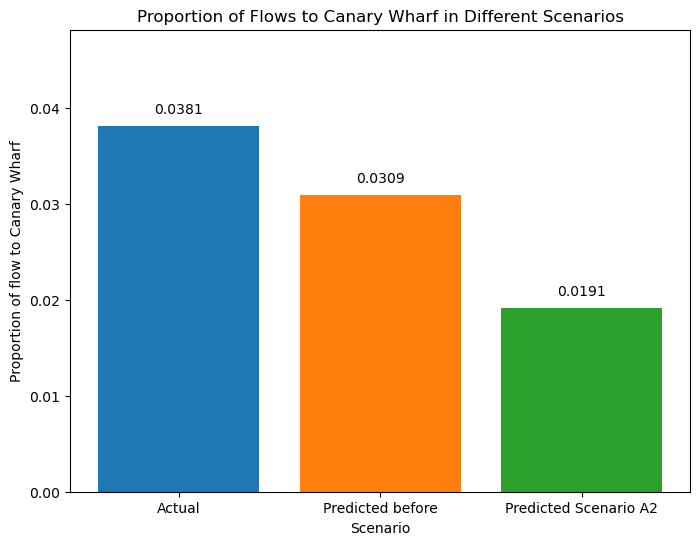

In [33]:
scenarios = ['Actual', 'Predicted before', 'Predicted Scenario A2']
proportions = [proportion_actual, proportion_A1, proportion_A2]

# Create a bar chart for the proportions
plt.figure(figsize=(8, 6))
bars = plt.bar(scenarios, proportions, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Proportion of Flows to Canary Wharf in Different Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Proportion of flow to Canary Wharf')
plt.ylim(0, max(proportions) + 0.01)  # Set y-axis limits to make differences more visible

# Adding the proportion values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

## IV.2. Scenario B

### Scenario B-1

In [34]:
# Assign the new value to beta to change the 'cost'
betaB_1 = 1.5*beta2
# Calculate some new wj^alpha and d_ij^beta values
distance_betaB_1 = np.exp(London_OD["distance"]*-betaB_1)
# Calcualte the first stage of the Ai value
London_OD["Ai3"] = jobs_gamma2 * distance_betaB_1
# Do the sum over all js bit
A_i3 = pd.DataFrame(London_OD.groupby(["station_origin"])["Ai3"].agg("sum"))
# Divide into 1
A_i3["Ai3"] = 1/A_i3["Ai3"]
A_i3.rename(columns={"Ai3":"A_i3"}, inplace=True)
# Write the A_i value back into the dataframe
London_OD = London_OD.merge(A_i3, left_on="station_origin", right_index=True, how="left")
London_OD

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,...,prodsimest2,scenario_A,Ai1,A_i1,predict_A_1,Ai2,A_i2,predict_A_2,Ai3,A_i3
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,...,78.0,78549.0,1432.231104,0.000091,78.0,1432.231104,0.000097,83.0,768.354601,0.000119
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,...,1.0,442.0,27.026714,0.000091,1.0,27.026714,0.000097,2.0,14.084773,0.000119
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,...,4.0,665.0,75.982904,0.000091,4.0,75.982904,0.000097,4.0,56.904408,0.000119
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,...,99.0,29386.0,1834.127323,0.000091,99.0,1086.638601,0.000097,63.0,1242.378620,0.000119
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,...,56.0,15428.0,1034.750388,0.000091,56.0,1034.750388,0.000097,60.0,872.373508,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,7892,3342,8.973605,8.114325,...,99.0,3342.0,58.874685,0.000213,99.0,58.874685,0.000230,107.0,21.095509,0.000437
61409,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,7892,5487,8.973605,8.610137,...,295.0,5487.0,175.878367,0.000213,295.0,175.878367,0.000230,320.0,90.324464,0.000437
61410,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,7892,400,8.973605,5.991465,...,36.0,400.0,21.416897,0.000213,36.0,21.416897,0.000230,39.0,10.317367,0.000437
61411,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,7892,893,8.973605,6.794587,...,125.0,893.0,74.528041,0.000213,125.0,74.528041,0.000230,135.0,49.454543,0.000437


In [35]:
# Assign the new value to the Formula
London_OD["predict_B_1"] = London_OD["A_i3"]*London_OD["O_i"]*jobs_gamma2*distance_betaB_1
# Round the estimates
London_OD["predict_B_1"] = round(London_OD["predict_B_1"],0)

# Create a pivot tabel
London_flows_B1 = London_OD.pivot_table(values ="predict_B_1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_flows_B1

/tmp/ipykernel_27145/4013428436.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flows_B1 = London_OD.pivot_table(values ="predict_B_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/4013428436.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flows_B1 = London_OD.pivot_table(values ="predict_B_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/4013428436.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,7.0,NaN,20.0,0.0,NaN,10.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,47.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,51.0,NaN,NaN,0.0,0.0,NaN,30.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,50.0,NaN,NaN,NaN,NaN,22.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


In [36]:
canary_wharf_London_flows_B1 = London_flows_B1["Canary Wharf"]
canary_wharf_London_flows_B1

station_origin
Abbey Road             89.0
Acton Central           NaN
Acton Town             16.0
Aldgate                65.0
Aldgate East          100.0
                     ...   
Woodford              250.0
Woodgrange Park         NaN
Woodside Park          23.0
Woolwich Arsenal     1429.0
All                 46460.0
Name: Canary Wharf, Length: 399, dtype: float64

In [37]:
proportion_B1 = round(46460/1540889, 4)
proportion_B1

0.0302

In [38]:
# If we directly adjust cost parameters without adjusting Ai
London_OD["scenarioB1"] = np.exp(London_OD["alpha_i2"]+gamma2*London_OD["log_jobs"] 
                                 - betaB_1*London_OD["distance"])
# Round the estimates
London_OD["scenarioB1"] = round(London_OD["scenarioB1"],0)

# Create a pivot tabel
London_flowsB1 = London_OD.pivot_table(values ="scenarioB1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_flowsB1

/tmp/ipykernel_27145/2369235808.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flowsB1 = London_OD.pivot_table(values ="scenarioB1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/2369235808.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flowsB1 = London_OD.pivot_table(values ="scenarioB1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/2369235808.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used direc

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,457.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,677.0
Acton Town,NaN,NaN,NaN,4.0,3.0,NaN,9.0,0.0,NaN,5.0,...,4.0,1.0,0.0,12.0,NaN,0.0,NaN,0.0,NaN,1722.0
Aldgate,NaN,NaN,0.0,NaN,33.0,NaN,NaN,0.0,NaN,21.0,...,0.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2055.0
Aldgate East,NaN,NaN,0.0,36.0,NaN,NaN,0.0,0.0,NaN,22.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,12.0,17.0,NaN,NaN,NaN,NaN,8.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1662.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0
Woodside Park,NaN,NaN,0.0,5.0,5.0,NaN,0.0,NaN,NaN,11.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1017.0


### Scenario B-2

In [39]:
# Assign the new value to beta to change the 'cost'
betaB_2 = 3*beta2
# Calculate some new wj^alpha and d_ij^beta values
distance_betaB_2 = np.exp(London_OD["distance"]*-betaB_2)
# Calcualte the first stage of the Ai value
London_OD["Ai4"] = jobs_gamma2 * distance_betaB_2
# Do the sum over all js bit
A_i4 = pd.DataFrame(London_OD.groupby(["station_origin"])["Ai4"].agg("sum"))
# Divide into 1
A_i4["Ai4"] = 1/A_i4["Ai4"]
A_i4.rename(columns={"Ai4":"A_i4"}, inplace=True)
# Write the A_i value back into the dataframe
London_OD = London_OD.merge(A_i4, left_on="station_origin", right_index=True, how="left")
London_OD

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,log_population,log_jobs,...,predict_A_1,Ai2,A_i2,predict_A_2,Ai3,A_i3,predict_B_1,scenarioB1,Ai4,A_i4
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,599,78549,6.395262,11.271478,...,78.0,1432.231104,0.000097,83.0,768.354601,0.000119,55.0,42.0,118.633538,0.000220
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,599,442,6.395262,6.091310,...,1.0,27.026714,0.000097,2.0,14.084773,0.000119,1.0,1.0,1.993516,0.000220
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,599,665,6.395262,6.499787,...,4.0,75.982904,0.000097,4.0,56.904408,0.000119,4.0,3.0,23.902095,0.000220
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,599,58772,6.395262,10.981421,...,99.0,1086.638601,0.000097,63.0,1242.378620,0.000119,89.0,67.0,386.124568,0.000220
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,599,15428,6.395262,9.643939,...,56.0,1034.750388,0.000097,60.0,872.373508,0.000119,62.0,47.0,522.760880,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,7892,3342,8.973605,8.114325,...,99.0,58.874685,0.000230,107.0,21.095509,0.000437,73.0,35.0,0.970452,0.002733
61409,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,7892,5487,8.973605,8.610137,...,295.0,175.878367,0.000230,320.0,90.324464,0.000437,311.0,152.0,12.234446,0.002733
61410,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,7892,400,8.973605,5.991465,...,36.0,21.416897,0.000230,39.0,10.317367,0.000437,36.0,17.0,1.153469,0.002733
61411,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,7892,893,8.973605,6.794587,...,125.0,74.528041,0.000230,135.0,49.454543,0.000437,170.0,83.0,14.449927,0.002733


In [40]:
# Assign the new value to the Formula
London_OD["predict_B_2"] = London_OD["A_i4"]*London_OD["O_i"]*jobs_gamma2*distance_betaB_2
# Round the estimates
London_OD["predict_B_2"] = round(London_OD["predict_B_2"],0)

# Create a pivot tabel
London_flows_B2 = London_OD.pivot_table(values ="predict_B_2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_flows_B2

/tmp/ipykernel_27145/3626001491.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flows_B2 = London_OD.pivot_table(values ="predict_B_2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3626001491.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flows_B2 = London_OD.pivot_table(values ="predict_B_2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3626001491.py:7: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,31.0,0.0,NaN,1.0,...,1.0,0.0,0.0,29.0,NaN,0.0,NaN,0.0,NaN,3737.0
Aldgate,NaN,NaN,0.0,NaN,71.0,NaN,NaN,0.0,NaN,28.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2881.0
Aldgate East,NaN,NaN,0.0,79.0,NaN,NaN,0.0,0.0,NaN,28.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,8.0,15.0,NaN,NaN,NaN,NaN,3.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4857.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,0.0,3.0,2.0,NaN,0.0,NaN,NaN,11.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3083.0


In [41]:
canary_wharf_London_flows_B2 = London_flows_B2["Canary Wharf"]
canary_wharf_London_flows_B2

station_origin
Abbey Road             51.0
Acton Central           NaN
Acton Town              1.0
Aldgate                31.0
Aldgate East           67.0
                     ...   
Woodford               84.0
Woodgrange Park         NaN
Woodside Park           1.0
Woolwich Arsenal      927.0
All                 42998.0
Name: Canary Wharf, Length: 399, dtype: float64

In [42]:
proportion_B2 = round(45255/1540831, 4)
proportion_B2

0.0294

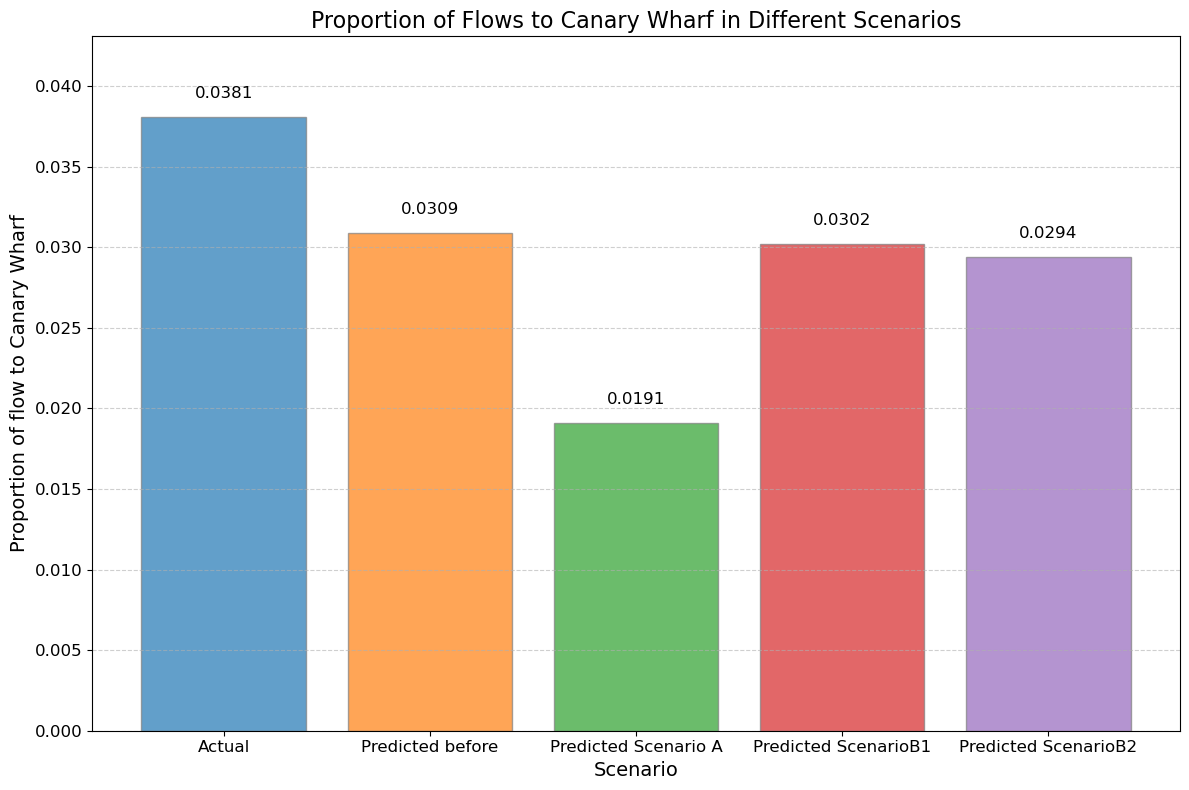

In [43]:
# Visualize the final result

scenarios = ['Actual', 'Predicted before', 'Predicted Scenario A', 'Predicted ScenarioB1', 'Predicted ScenarioB2']
proportions = [proportion_actual, proportion_A1, proportion_A2, proportion_B1, proportion_B2]

# Define colors for each scenario for better visual distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a bar chart for the proportions
plt.figure(figsize=(12, 8))  # Enhanced figure size for better readability
bars = plt.bar(scenarios, proportions, color=colors, alpha=0.7, edgecolor='grey')

plt.title('Proportion of Flows to Canary Wharf in Different Scenarios', fontsize=16)
plt.xlabel('Scenario', fontsize=14)
plt.ylabel('Proportion of flow to Canary Wharf', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(proportions) + 0.005)  # Adjusted for better top label display

# Adding horizontal grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adding the proportion values above the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()  # Adjust layout to make sure everything fits without clipping
plt.show()

In [44]:
# If we directly adjust cost parameters without adjusting Ai
London_OD["scenarioB2"] = np.exp(London_OD["alpha_i2"]+gamma2*London_OD["log_jobs"] 
                                 - betaB_2*London_OD["distance"])
# Round the estimates
London_OD["scenarioB2"] = round(London_OD["scenarioB2"],0)

# Create a pivot tabel
London_flowsB2 = London_OD.pivot_table(values ="scenarioB2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
London_flowsB2

/tmp/ipykernel_27145/3944985696.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flowsB2 = London_OD.pivot_table(values ="scenarioB2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3944985696.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  London_flowsB2 = London_OD.pivot_table(values ="scenarioB2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_27145/3944985696.py:8: FutureWarning: The provided callable <function sum at 0x7f6dc47da660> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used direc

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,244.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,3.0,0.0,NaN,0.0,...,0.0,0.0,0.0,3.0,NaN,0.0,NaN,0.0,NaN,356.0
Aldgate,NaN,NaN,0.0,NaN,24.0,NaN,NaN,0.0,NaN,9.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,967.0
Aldgate East,NaN,NaN,0.0,26.0,NaN,NaN,0.0,0.0,NaN,9.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,194.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,106.0


/tmp/ipykernel_27145/3027651231.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = London_OD.groupby('distance_category').agg({'flows':'mean', 'predict_B_1':'mean', 'predict_B_2':'mean'})


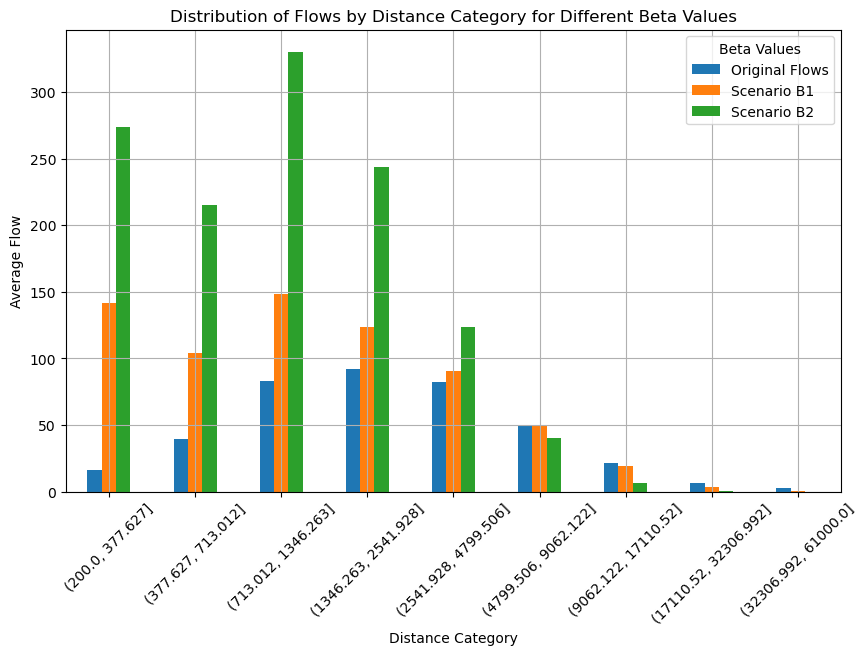

In [45]:
# Control Ai unchanged

# Set spacing
bins = np.logspace(np.log10(200), np.log10(61000), num=10)
London_OD['distance_category'] = pd.cut(London_OD['distance'], bins)

# Then aggregate the data by distance classification and calculate the average flow rate for each interval
grouped = London_OD.groupby('distance_category').agg({'flows':'mean', 'predict_B_1':'mean', 'predict_B_2':'mean'})

# Draw a bar chart to compare the flow distribution under different values
grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Flows by Distance Category for Different Beta Values')
plt.xlabel('Distance Category')
plt.ylabel('Average Flow')
plt.legend(['Original Flows', 'Scenario B1', 'Scenario B2'], title='Beta Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_27145/3204112711.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = London_OD.groupby('distance_category').agg({'flows':'mean', 'scenarioB1':'mean', 'scenarioB2':'mean'})


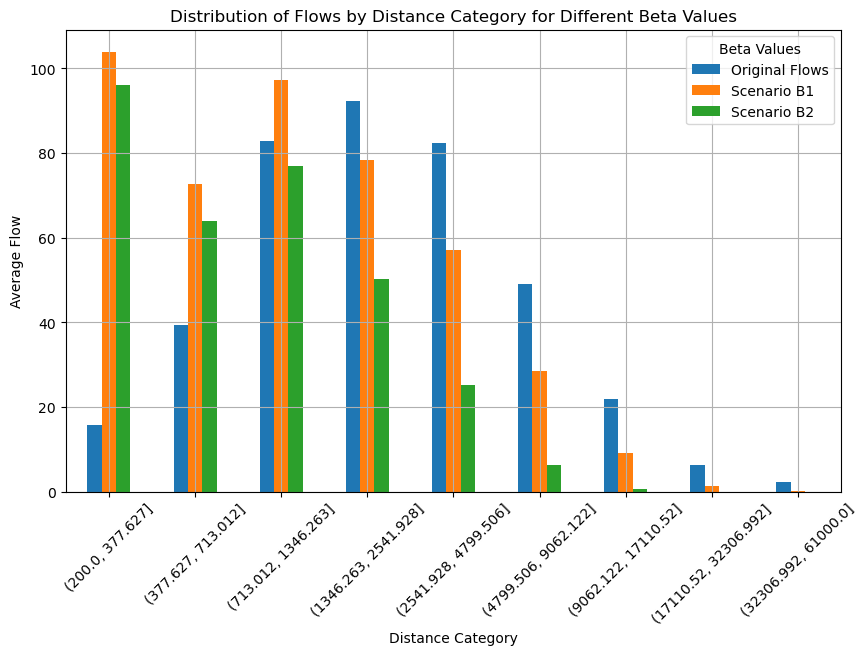

In [46]:
# Do not control Ai

# Set spacing
bins = np.logspace(np.log10(200), np.log10(61000), num=10)
London_OD['distance_category'] = pd.cut(London_OD['distance'], bins)

# Then aggregate the data by distance classification and calculate the average flow rate for each interval
grouped = London_OD.groupby('distance_category').agg({'flows':'mean', 'scenarioB1':'mean', 'scenarioB2':'mean'})

# Draw a bar chart to compare the flow distribution under different values
grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Flows by Distance Category for Different Beta Values')
plt.xlabel('Distance Category')
plt.ylabel('Average Flow')
plt.legend(['Original Flows', 'Scenario B1', 'Scenario B2'], title='Beta Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()